In [1]:
import os
import pickle
from pathlib import Path

In [2]:
import ipywidgets as widgets
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
import torch
from torch import Tensor
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

In [4]:
from dataset import VideoFrameDataset
from srcnn import SRCNN
from visualization import show_image

In [5]:
def transform(frame: np.ndarray) -> tuple[Tensor, Tensor]:
    TARGET_FRAME_SIZE = (720, 1280)
    DOWNSAMPLED_FRAME_SIZE = (180, 320)
    MIN_VALUE = -64
    MAX_VALUE = 64

    with torch.no_grad():
        frame = torch.from_numpy(frame).permute((2, 0, 1)).float()
        downsampled_frame = F.interpolate(
            frame.unsqueeze(0), size=DOWNSAMPLED_FRAME_SIZE, mode="bilinear"
        ).squeeze(0)
        resampled_frame = F.interpolate(
            downsampled_frame.unsqueeze(0), size=TARGET_FRAME_SIZE, mode="bilinear"
        ).squeeze(0)
        frame = F.interpolate(
            frame.unsqueeze(0), size=TARGET_FRAME_SIZE, mode="bilinear"
        ).squeeze(0)
        target = frame - resampled_frame

        target = (target - MIN_VALUE) / (MAX_VALUE - MIN_VALUE) * 255
        target = torch.clamp(target, 0, 255)

        return resampled_frame, target


video_path = os.fspath(Path.cwd().glob("*.mp4").__next__())
dataset = VideoFrameDataset(video_path, transform)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    pin_memory_device="cuda",
)

Loading video frames: 100%|██████████| 2416/2416 [00:04<00:00, 504.44it/s]


In [6]:
model_args = {
    "f1": 9,
    "f2": 1,
    "f3": 5,
    "n1": 64,
    "n2": 32,
    "qconfig": torch.ao.quantization.get_default_qat_qconfig("x86"),
}

In [7]:
model = SRCNN(**model_args).to("cuda")
optimizer = Adam(model.parameters(), lr=1e-4)

model.train()
epoch_losses = []
for epoch in range(1, 40 + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to("cuda"), targets.to("cuda")
        outputs = model(inputs, quant=False)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best.pth")
        model.eval()
        with torch.no_grad():
            torch.save(model.state_dict(), "best.pth")

    epoch_losses.append(epoch_loss)

Epoch 1: 100%|██████████| 151/151 [00:32<00:00,  4.66it/s, batch_loss=1.66e+3]


Epoch loss: 4088.0462573727236
Saving best.pth


Epoch 2: 100%|██████████| 151/151 [00:29<00:00,  5.14it/s, batch_loss=1.73e+3]


Epoch loss: 1640.575265644402
Saving best.pth


Epoch 3: 100%|██████████| 151/151 [00:29<00:00,  5.13it/s, batch_loss=1.5e+3] 


Epoch loss: 1420.504689601873
Saving best.pth


Epoch 4: 100%|██████████| 151/151 [00:29<00:00,  5.11it/s, batch_loss=961]    


Epoch loss: 1359.3520600779957
Saving best.pth


Epoch 5: 100%|██████████| 151/151 [00:29<00:00,  5.11it/s, batch_loss=1.77e+3]


Epoch loss: 1338.9308063431292
Saving best.pth


Epoch 6: 100%|██████████| 151/151 [00:29<00:00,  5.12it/s, batch_loss=1.36e+3]


Epoch loss: 1293.766588223691
Saving best.pth


Epoch 7: 100%|██████████| 151/151 [00:29<00:00,  5.15it/s, batch_loss=1.18e+3]


Epoch loss: 1268.6518162607358
Saving best.pth


Epoch 8: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=1.42e+3]


Epoch loss: 1247.6308468446036
Saving best.pth


Epoch 9: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=898]    


Epoch loss: 1220.4654148935483
Saving best.pth


Epoch 10: 100%|██████████| 151/151 [00:29<00:00,  5.15it/s, batch_loss=1.2e+3] 


Epoch loss: 1214.1320647182843
Saving best.pth


Epoch 11: 100%|██████████| 151/151 [00:29<00:00,  5.06it/s, batch_loss=1.11e+3]


Epoch loss: 1191.0181363339457
Saving best.pth


Epoch 12: 100%|██████████| 151/151 [00:29<00:00,  5.15it/s, batch_loss=791]    


Epoch loss: 1174.2373248978167
Saving best.pth


Epoch 13: 100%|██████████| 151/151 [00:29<00:00,  5.13it/s, batch_loss=1.11e+3]


Epoch loss: 1171.138420458661
Saving best.pth


Epoch 14: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=880]    


Epoch loss: 1166.6290052805516
Saving best.pth


Epoch 15: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, batch_loss=860]    


Epoch loss: 1150.990360487376
Saving best.pth


Epoch 16: 100%|██████████| 151/151 [00:29<00:00,  5.17it/s, batch_loss=858]    


Epoch loss: 1144.9651735823675
Saving best.pth


Epoch 17: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=1.26e+3]


Epoch loss: 1142.7337589895487
Saving best.pth


Epoch 18: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, batch_loss=1.37e+3]


Epoch loss: 1123.2221190597838
Saving best.pth


Epoch 19: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=851]    


Epoch loss: 1122.5011127800342
Saving best.pth


Epoch 20: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=1.32e+3]


Epoch loss: 1111.4089937525869
Saving best.pth


Epoch 21: 100%|██████████| 151/151 [00:29<00:00,  5.11it/s, batch_loss=1.28e+3]


Epoch loss: 1120.910628767203


Epoch 22: 100%|██████████| 151/151 [00:29<00:00,  5.10it/s, batch_loss=1.71e+3]


Epoch loss: 1108.4885949141142
Saving best.pth


Epoch 23: 100%|██████████| 151/151 [00:29<00:00,  5.13it/s, batch_loss=1.21e+3]


Epoch loss: 1090.5049030228167
Saving best.pth


Epoch 24: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, batch_loss=1.22e+3]


Epoch loss: 1080.184475728218
Saving best.pth


Epoch 25: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=1.23e+3]


Epoch loss: 1090.8887892969396


Epoch 26: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, batch_loss=913]    


Epoch loss: 1072.2298790129605
Saving best.pth


Epoch 27: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=721]    


Epoch loss: 1068.127018606426
Saving best.pth


Epoch 28: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=1.25e+3]


Epoch loss: 1069.6738362091266


Epoch 29: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, batch_loss=1.27e+3]


Epoch loss: 1066.5892540129605
Saving best.pth


Epoch 30: 100%|██████████| 151/151 [00:29<00:00,  5.15it/s, batch_loss=681]    


Epoch loss: 1057.2644135936207
Saving best.pth


Epoch 31: 100%|██████████| 151/151 [00:29<00:00,  5.13it/s, batch_loss=918]    


Epoch loss: 1037.9439947873552
Saving best.pth


Epoch 32: 100%|██████████| 151/151 [00:29<00:00,  5.17it/s, batch_loss=842]    


Epoch loss: 1061.0019496892462


Epoch 33: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, batch_loss=1.11e+3]


Epoch loss: 1027.879547523347
Saving best.pth


Epoch 34: 100%|██████████| 151/151 [00:29<00:00,  5.17it/s, batch_loss=1.42e+3]


Epoch loss: 1019.5192654843362
Saving best.pth


Epoch 35: 100%|██████████| 151/151 [00:29<00:00,  5.17it/s, batch_loss=1.25e+3]


Epoch loss: 1014.8455826715128
Saving best.pth


Epoch 36: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, batch_loss=619]    


Epoch loss: 1011.1948808076365
Saving best.pth


Epoch 37: 100%|██████████| 151/151 [00:29<00:00,  5.19it/s, batch_loss=492]    


Epoch loss: 1000.9238938085291
Saving best.pth


Epoch 38: 100%|██████████| 151/151 [00:29<00:00,  5.19it/s, batch_loss=807]    


Epoch loss: 992.8689878350062
Saving best.pth


Epoch 39: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, batch_loss=609]    


Epoch loss: 993.4370497141452


Epoch 40: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, batch_loss=780]    


Epoch loss: 997.9740113517306


Text(0, 0.5, 'Loss')

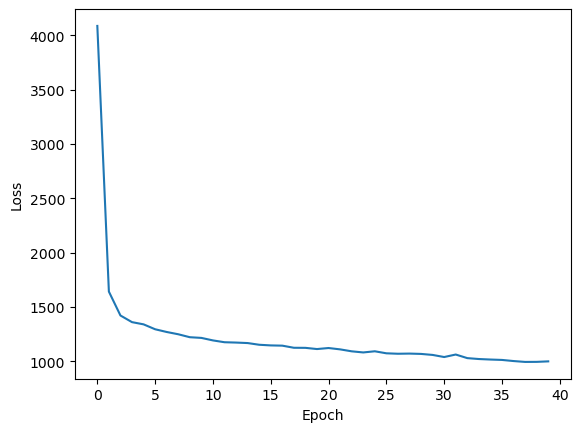

In [8]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [9]:
model = SRCNN(**model_args).to("cuda")
model.eval()
model.load_state_dict(torch.load("best.pth"))
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
optimizer = Adam(model_qat.parameters(), lr=1e-4)

epoch_losses = []
for epoch in range(1, 40 + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to("cuda"), targets.to("cuda")
        outputs = model_qat(inputs, quant=True)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best_qat.pth")
        model_qat.eval()
        with torch.no_grad():
            torch.save(model_qat.state_dict(), "best_qat.pth")

    epoch_losses.append(epoch_loss)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1:   0%|          | 0/151 [00:00<?, ?it/s]/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Us

Epoch loss: 1025.38659364814
Saving best_qat.pth


Epoch 2: 100%|██████████| 151/151 [00:34<00:00,  4.32it/s, batch_loss=1.24e+3]


Epoch loss: 1028.9440182313224


Epoch 3: 100%|██████████| 151/151 [00:34<00:00,  4.32it/s, batch_loss=997]    


Epoch loss: 1034.2783570952763


Epoch 4: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=1.09e+3]


Epoch loss: 1052.7862754973355


Epoch 5: 100%|██████████| 151/151 [00:34<00:00,  4.34it/s, batch_loss=1.27e+3]


Epoch loss: 1053.534832076521


Epoch 6: 100%|██████████| 151/151 [00:34<00:00,  4.36it/s, batch_loss=1.24e+3]


Epoch loss: 1062.5369517345302


Epoch 7: 100%|██████████| 151/151 [00:34<00:00,  4.38it/s, batch_loss=959]    


Epoch loss: 1061.2744868196398


Epoch 8: 100%|██████████| 151/151 [00:34<00:00,  4.33it/s, batch_loss=898]    


Epoch loss: 1032.399058158824


Epoch 9: 100%|██████████| 151/151 [00:34<00:00,  4.34it/s, batch_loss=1.04e+3]


Epoch loss: 1026.6194280157026


Epoch 10: 100%|██████████| 151/151 [00:34<00:00,  4.35it/s, batch_loss=1.28e+3]


Epoch loss: 1015.941765791533
Saving best_qat.pth


Epoch 11: 100%|██████████| 151/151 [00:34<00:00,  4.38it/s, batch_loss=975]    


Epoch loss: 1026.731447737738


Epoch 12: 100%|██████████| 151/151 [00:34<00:00,  4.38it/s, batch_loss=1.04e+3]


Epoch loss: 1014.7388279390651
Saving best_qat.pth


Epoch 13: 100%|██████████| 151/151 [00:34<00:00,  4.38it/s, batch_loss=747]    


Epoch loss: 1018.9561569517022


Epoch 14: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=884]    


Epoch loss: 987.8895304092508
Saving best_qat.pth


Epoch 15: 100%|██████████| 151/151 [00:34<00:00,  4.38it/s, batch_loss=1.13e+3]


Epoch loss: 1005.088878101071


Epoch 16: 100%|██████████| 151/151 [00:34<00:00,  4.36it/s, batch_loss=1.27e+3]


Epoch loss: 1007.5036960627069


Epoch 17: 100%|██████████| 151/151 [00:34<00:00,  4.35it/s, batch_loss=1.03e+3]


Epoch loss: 993.9673405325176


Epoch 18: 100%|██████████| 151/151 [00:34<00:00,  4.36it/s, batch_loss=926]    


Epoch loss: 993.8614429195985


Epoch 19: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=1.05e+3]


Epoch loss: 1001.6838783112582


Epoch 20: 100%|██████████| 151/151 [00:34<00:00,  4.38it/s, batch_loss=1.27e+3]


Epoch loss: 978.6196163758536
Saving best_qat.pth


Epoch 21: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=1.22e+3]


Epoch loss: 963.3162744787355
Saving best_qat.pth


Epoch 22: 100%|██████████| 151/151 [00:34<00:00,  4.36it/s, batch_loss=1.08e+3]


Epoch loss: 984.9932590509882


Epoch 23: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=819]    


Epoch loss: 947.0150700247051
Saving best_qat.pth


Epoch 24: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=819]    


Epoch loss: 956.6843997374276


Epoch 25: 100%|██████████| 151/151 [00:35<00:00,  4.27it/s, batch_loss=986]    


Epoch loss: 934.8884354142954
Saving best_qat.pth


Epoch 26: 100%|██████████| 151/151 [00:34<00:00,  4.36it/s, batch_loss=961]    


Epoch loss: 928.4025808170142
Saving best_qat.pth


Epoch 27: 100%|██████████| 151/151 [00:34<00:00,  4.35it/s, batch_loss=919]    


Epoch loss: 949.0013023528043


Epoch 28: 100%|██████████| 151/151 [00:34<00:00,  4.33it/s, batch_loss=791]    


Epoch loss: 924.3328046988178
Saving best_qat.pth


Epoch 29: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=977]    


Epoch loss: 934.6057393661398


Epoch 30: 100%|██████████| 151/151 [00:34<00:00,  4.35it/s, batch_loss=755]    


Epoch loss: 916.5312904206332
Saving best_qat.pth


Epoch 31: 100%|██████████| 151/151 [00:34<00:00,  4.38it/s, batch_loss=842]    


Epoch loss: 894.7796442903431
Saving best_qat.pth


Epoch 32: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=1.14e+3]


Epoch loss: 916.4651960158191


Epoch 33: 100%|██████████| 151/151 [00:34<00:00,  4.37it/s, batch_loss=1.02e+3]


Epoch loss: 915.4299029419753


Epoch 34: 100%|██████████| 151/151 [00:34<00:00,  4.35it/s, batch_loss=981]    


Epoch loss: 902.4389727257735


Epoch 35: 100%|██████████| 151/151 [00:34<00:00,  4.36it/s, batch_loss=1.08e+3]


Epoch loss: 901.4359555276025


Epoch 36: 100%|██████████| 151/151 [00:34<00:00,  4.35it/s, batch_loss=1.32e+3]


Epoch loss: 858.370299282453
Saving best_qat.pth


Epoch 37: 100%|██████████| 151/151 [00:34<00:00,  4.35it/s, batch_loss=992]    


Epoch loss: 900.8235031026878


Epoch 38: 100%|██████████| 151/151 [00:34<00:00,  4.33it/s, batch_loss=1.23e+3]


Epoch loss: 866.9261272506209


Epoch 39: 100%|██████████| 151/151 [00:34<00:00,  4.34it/s, batch_loss=490]    


Epoch loss: 857.4817965678031
Saving best_qat.pth


Epoch 40: 100%|██████████| 151/151 [00:34<00:00,  4.38it/s, batch_loss=809]    

Epoch loss: 814.59025927411
Saving best_qat.pth


Text(0, 0.5, 'Loss')

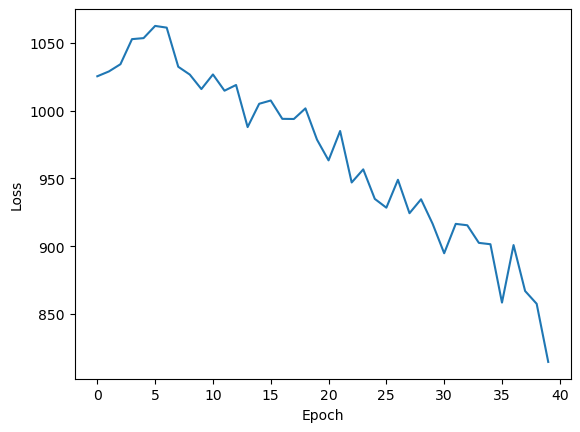

In [10]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [7]:
model = SRCNN(**model_args).to("cuda")
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.load_state_dict(torch.load("best_qat.pth"))
model_qat.cpu()
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
torch.save(model_converted.state_dict(), "converted.pth")

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [7]:
FIGURE_SIZE = (12, 8)

In [8]:
%matplotlib inline

model = SRCNN(**model_args)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
model_converted.load_state_dict(torch.load("converted.pth"))

def animate_dataset(index):
    _, input_axes = plt.subplots(1, 1, figsize=FIGURE_SIZE)
    input_axes.set_title("Input")
    _, output_axes = plt.subplots(1, 1, figsize=FIGURE_SIZE)
    output_axes.set_title("Output")
    _, target_axes = plt.subplots(1, 1, figsize=FIGURE_SIZE)
    target_axes.set_title("Target")

    test_input, test_target = dataset[index]
    test_output = model_converted(test_input.unsqueeze(0), quant=True).squeeze(0)
    print(type(test_output), test_output.shape)
    show_image(input_axes, test_input)
    show_image(output_axes, test_output)
    show_image(target_axes, test_target)


widgets.interact(animate_dataset, index=(0, len(dataset) - 1, 1))

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/_utils.py:404: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


interactive(children=(IntSlider(value=1207, description='index', max=2415), Output()), _dom_classes=('widget-i…

<function __main__.animate_dataset(index)>

In [9]:
s = [21, 14, 14]

u = []
v = []
weights = []

x_scale_keys = ["quant.scale", "conv_layers.0.scale", "conv_layers.1.scale"]
x_zero_point_keys = [
    "quant.zero_point",
    "conv_layers.0.zero_point",
    "conv_layers.1.zero_point",
]

for i in range(3):
    conv_layers_weight = model_converted.state_dict()[f"conv_layers.{i}.weight"]
    bias = model_converted.state_dict()[f"conv_layers.{i}.bias"]

    x_scale = model_converted.state_dict()[x_scale_keys[i]]
    y_scale = model_converted.state_dict()[f"conv_layers.{i}.scale"]
    A_scale = conv_layers_weight.q_per_channel_scales()

    u.append(x_scale / y_scale * A_scale * (2 ** s[i]))
    v.append((bias / y_scale) * (2 ** s[i]))

    A_q = conv_layers_weight.int_repr()
    x_0 = model_converted.state_dict()[x_zero_point_keys[i]]

    weight = A_q * u[i].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    weights.append(weight)

weights[0] = weights[0] / model_converted.state_dict()["quant.scale"]
weights[2] = weights[2] * y_scale

Text(0.5, 1.0, 'Output')

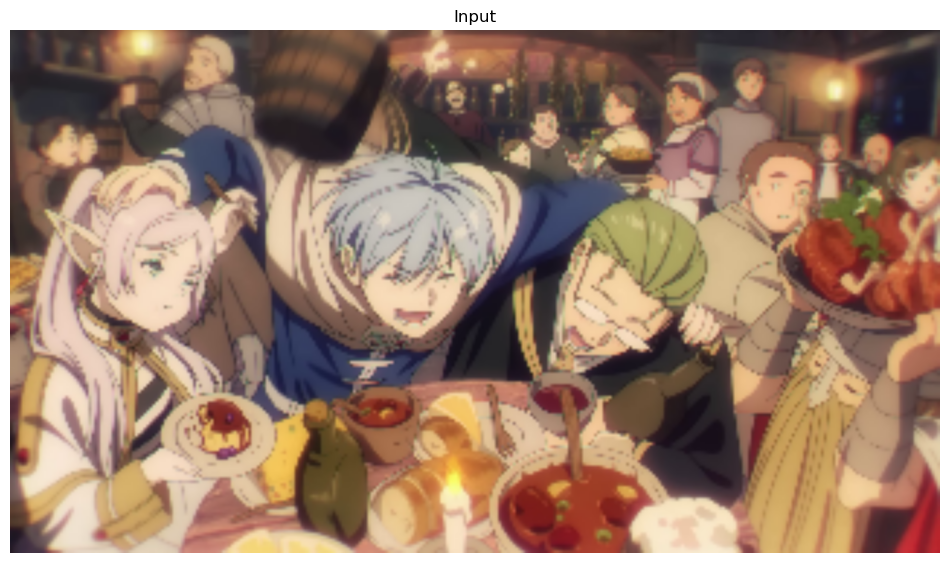

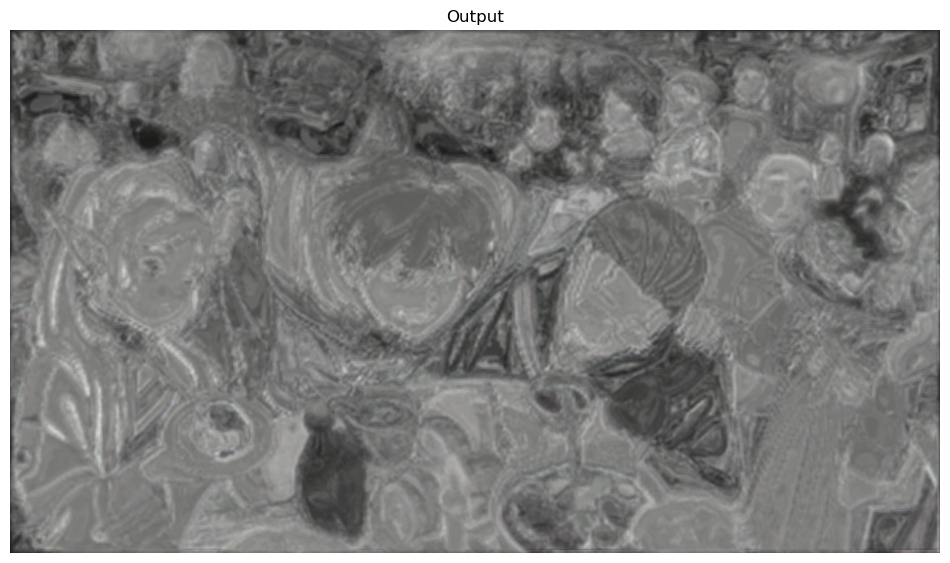

In [10]:
ACTIVATION_WIDTH = 9
ACTIVATION_MIN = -(2 ** (ACTIVATION_WIDTH - 1))
ACTIVATION_MAX = 2 ** (ACTIVATION_WIDTH - 1) - 1

WEIGHT_WIDTH = 25
WEIGHT_MIN = -(2 ** (WEIGHT_WIDTH - 1))
WEIGHT_MAX = 2 ** (WEIGHT_WIDTH - 1) - 1

DSP_OUTPUT_WIDTH = 48
DSP_OUTPUT_MIN = -(2 ** (DSP_OUTPUT_WIDTH - 1))
DSP_OUTPUT_MAX = 2 ** (DSP_OUTPUT_WIDTH - 1) - 1

test_input = dataset[1460][0].unsqueeze(0).double()
test_output = test_input

for i, weight in enumerate(weights):
    assert weight.min() >= WEIGHT_MIN, f"Weight {i} min: {weight.min()}"
    assert weight.max() <= WEIGHT_MAX, f"Weight {i} max: {weight.max()}"

    test_output = F.conv2d(
        test_output, weight.round(), v[i].round(), padding="same"
    ).round()
    assert test_output.min() >= DSP_OUTPUT_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= DSP_OUTPUT_MAX, f"Output {i} max: {test_output.max()}"

    test_output = F.relu(test_output * (2 ** -s[i])).floor()
    assert test_output.min() >= ACTIVATION_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= ACTIVATION_MAX, f"Output {i} max: {test_output.max()}"

test_output = test_output.floor()

_, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
show_image(ax, test_input)
plt.title("Input")

_, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
show_image(ax, test_output)
plt.title("Output")

In [11]:
with open("weights.pkl", "wb") as fp:
    pickle.dump(weights, fp)
with open("biases.pkl", "wb") as fp:
    pickle.dump(v, fp)